#  Introduction

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

# Load Data

In [205]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_all = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [206]:
df_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [207]:
df_all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# Feature Engineering 

## Treat Missing Values

In [208]:
df_all.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [209]:
df_all["Age"] = df_all["Age"].fillna(df_all["Age"].median())

df_all["Embarked"] = df_all['Embarked'].fillna(df_all['Embarked'].mode()[0])

df_all["Fare"] = df_all["Fare"].fillna(df_all['Fare'].median())

## Creating new Variables

In [210]:
# 
df_all['FamilySize'] = df_all['SibSp'] + df_all['Parch'] + 1
df_all['isAlone'] = 0
df_all.loc[df_all['FamilySize'] == 1, 'isAlone'] = 1
df_all['has_Cabin'] = df_all["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

df_all[['firstName','lastName']] = df_all.Name.str.split(",", expand = True) 
df_all = df_all.drop(["Name"], axis=1)

df_all['married'] = np.where(df_all['lastName'].str.contains("Mrs."), 1, 
                             np.where(df_all['lastName'].str.contains("Miss. "), 0, float(0)))


#  Exploratory Data Analysis

In [211]:
def bar_plot(variable): 
    # get feature
    var = df_all[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts() / len(df_all)
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))
    


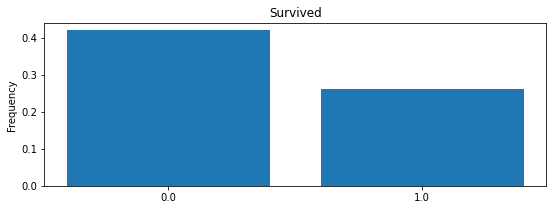

Survived: 
 0.0    0.419404
1.0    0.261268
Name: Survived, dtype: float64


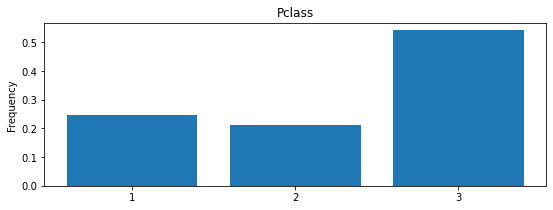

Pclass: 
 3    0.541635
1    0.246753
2    0.211612
Name: Pclass, dtype: float64


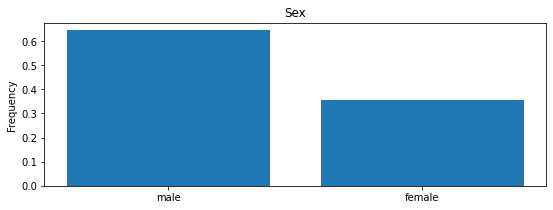

Sex: 
 male      0.644003
female    0.355997
Name: Sex, dtype: float64


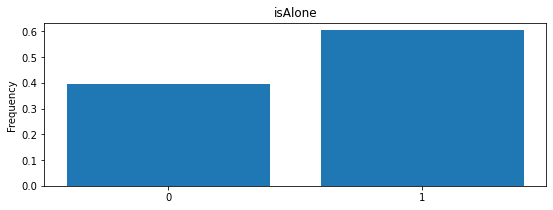

isAlone: 
 1    0.603514
0    0.396486
Name: isAlone, dtype: float64


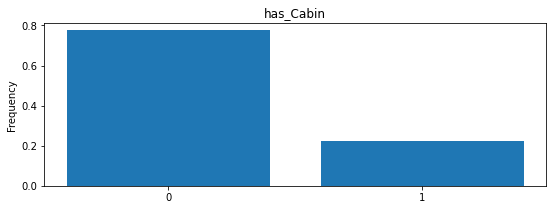

has_Cabin: 
 0    0.774637
1    0.225363
Name: has_Cabin, dtype: float64


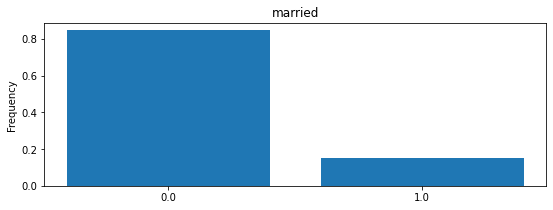

married: 
 0.0    0.846448
1.0    0.153552
Name: married, dtype: float64


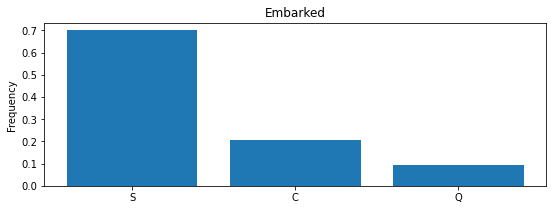

Embarked: 
 S    0.699771
C    0.206264
Q    0.093965
Name: Embarked, dtype: float64


In [212]:
categorical_variables = ["Survived", "Pclass", "Sex", "isAlone", "has_Cabin", "married", "Embarked"]
for var in categorical_variables:
    bar_plot(var)

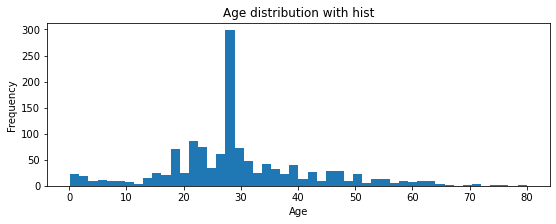

In [213]:
plt.figure(figsize = (9,3))
plt.hist(df_all["Age"], bins = 50)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("{} distribution with hist".format("Age"))
plt.show()

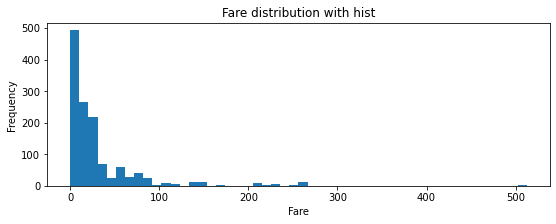

In [214]:
plt.figure(figsize = (9,3))
plt.hist(df_all["Fare"], bins = 50)
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("{} distribution with hist".format("Fare"))
plt.show()
    

In [215]:
df_all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,isAlone,has_Cabin,firstName,lastName,married
0,1,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0,Braund,Mr. Owen Harris,0.0
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),1.0
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,0,Heikkinen,Miss. Laina,0.0
3,4,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,2,0,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),1.0
4,5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,1,0,Allen,Mr. William Henry,0.0


## Model Building 

#### Drop not needed columns and create Dummy variables for categorical variables

In [216]:
df_all = df_all.drop(labels = ["firstName", "lastName", "Ticket", "Cabin"],axis = 1)
df_all = pd.get_dummies(df_all, columns=["Sex","Embarked"])

#### Split Data into Training and Validation set

In [217]:
# First Split data into train and test again
df_train = df_all[df_all["PassengerId"].isin(df_train["PassengerId"])]
df_test = df_all[df_all["PassengerId"].isin(df_test["PassengerId"])]

df_train = df_train.drop(labels = ["PassengerId"],axis = 1)

# Second Split df_train into train and validation
target = df_train["Survived"]
x = df_train.drop(labels = ["Survived"],axis = 1)

x_train, x_val, y_train, y_val = train_test_split(x, target, test_size=0.3)

#### Build and fit the model

In [222]:
x_train.head()
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

#### Predictions of the validation set

In [235]:
predictions = lr_model.predict(x_val)

#### Calculating Accuracy

In [234]:
print("Accuracy:",metrics.accuracy_score(y_val, predictions))

Accuracy: 0.7910447761194029


#### Plotting Confusion Matrix

Text(0.5, 257.44, 'Predicted label')

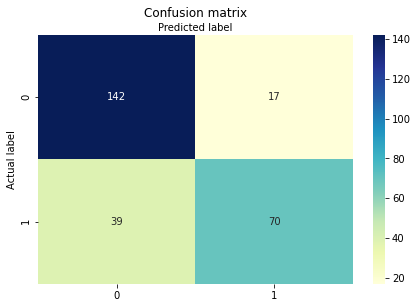

In [233]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')